In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
%load_ext line_profiler
%matplotlib inline

In [141]:
example_paths = glob.glob('examples/*.png')
example_paths

['examples\\0162681551.png',
 'examples\\0168366051.png',
 'examples\\0168639352.png']

In [142]:
examples = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in example_paths]

In [4]:
examples[0].shape

(256, 256)

In [5]:
import PIL.Image
import IPython.display

def show(arr):
    IPython.display.display(PIL.Image.fromarray(arr))

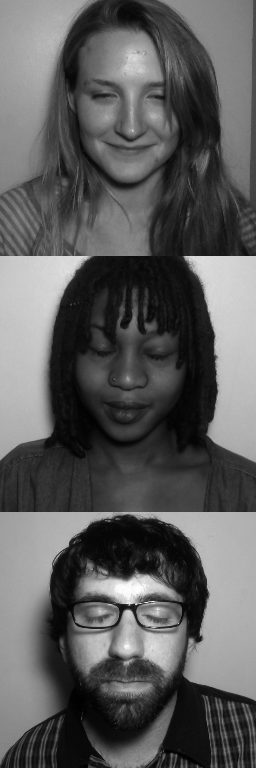

In [6]:
show(np.concatenate(examples, axis=0))

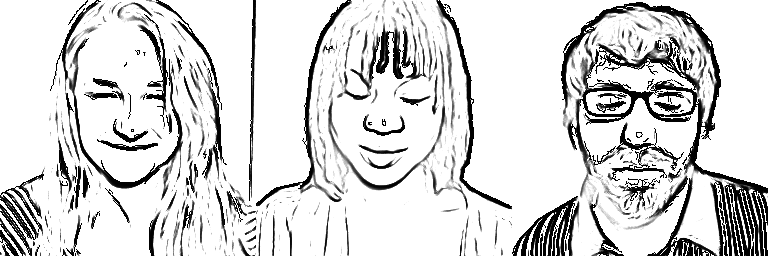

In [185]:
from functools import wraps
import time

def cld(gray, halfw = 4,smoothPasses = 4, sigma1 = .9, sigma2 = 3, tau = .975):
    cv2.imwrite('tmp_gray.bmp', gray)
    !wsl cld tmp_gray.bmp tmp_cld.bmp {halfw} {smoothPasses} {sigma1} {sigma2} {tau}
    return cv2.imread('tmp_cld.bmp', cv2.IMREAD_GRAYSCALE)

def raster_edges(gray, canny=(100, 200), **kwargs):
    edges = 255 - cv2.Canny(gray, *canny)
    edges &= cld(gray, **kwargs)
    """ 
    thres = cv2.adaptiveThreshold(gray, 
                    255, 
                    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                    thresholdType=cv2.THRESH_BINARY,
                    blockSize=5,
                    C=5)
    """
    return edges


gray = examples[1]
edges = [raster_edges(ex) for ex in examples]
show(np.concatenate(edges, axis=1))

In [8]:
edges = raster_edges(gray)
cv2.imwrite("output.bmp", edges)
!.\potrace-1.16.win64\potrace.exe output.bmp -o output.geojson -b geojson
!.\potrace-1.16.win64\potrace.exe output.bmp -o output.svg -b svg

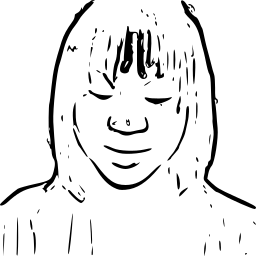

In [9]:
IPython.display.SVG('output.svg')

In [10]:
import json
with open('output.geojson') as fp:
    geojson = json.load(fp)

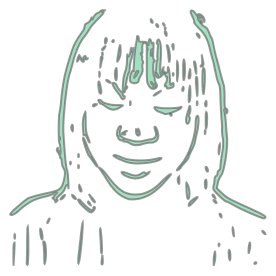

In [11]:
from shapely import geometry as geom

shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]
geom.GeometryCollection(shapes)

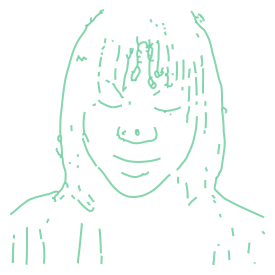

In [12]:
from centerline.geometry import Centerline 
from shapely import ops
import tqdm
def extract_centerlines(shapes):
    shapes = (shape.buffer(0) for shape in shapes)
    polys = [poly for poly in shapes if type(poly) == geom.Polygon and type(poly.envelope) == geom.Polygon]
    centerlines = [Centerline(p, valid=True) for p in polys]
    
    center_geoms = [line.geoms for line in centerlines]
    center_geom_lines = [geom.MultiLineString(line) for line in center_geoms]
    center_geom_lines = [ops.linemerge(line) for line in center_geom_lines]
    return center_geom_lines

# profile: 
# %lprun -u 0.001 -f extract_centerlines geom.GeometryCollection(extract_centerlines(shapes))
center_geom_lines = extract_centerlines(shapes)
geom.GeometryCollection(center_geom_lines)

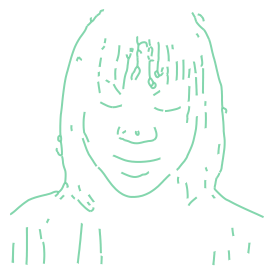

In [13]:
def explode_multilines(lines):
    out = []
    for line in lines:
        if type(line) == geom.multilinestring.MultiLineString:
            out.extend(subline for subline in line)
        else:
            out.append(line)
    return out

center_geom_lines = explode_multilines(center_geom_lines)

center_geom_lines = [line for line in center_geom_lines 
                     if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

geom.GeometryCollection(center_geom_lines)

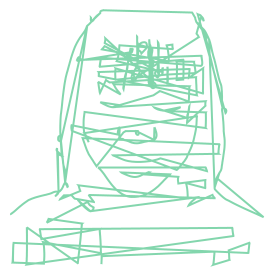

In [14]:
def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

merge_naive(center_geom_lines)

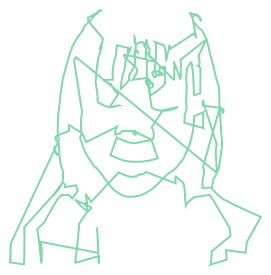

In [15]:
from math import sqrt

def greedy_reorder(lines):
    ''' Reorder list of LineStrings greedily by lowest tail-tip distance'''
    lines = lines[:]
    curr = lines.pop(0)
    out = []
    while len(lines) > 0:
        start_curr = geom.Point(curr.coords[0])
        end_curr = geom.Point(curr.coords[-1])
        dist = float('+inf')
        nearest_tail = None
        for other in lines:
            start_o = geom.Point(other.coords[0])
            end_o = geom.Point(other.coords[-1])
            if end_curr.distance(start_o) < dist:
                dist = end_curr.distance(start_o)
                nearest_tail = other
            elif end_curr.distance(end_o) < dist:
                dist = end_curr.distance(end_o)
                other.coords = list(other.coords)[::-1]
                nearest_tail = other
        lines.remove(nearest_tail)
        out.append(nearest_tail)
        curr = nearest_tail
    return out

ordered_lines = greedy_reorder(center_geom_lines)
merge_naive(ordered_lines)

We can try ordering the lines by their distance to the center as the first paths in the list have more next-lines to chose from, and so hopefully the center of the face will get the best "picks".
We can also try ordering by start point closest to center or end point closest to center

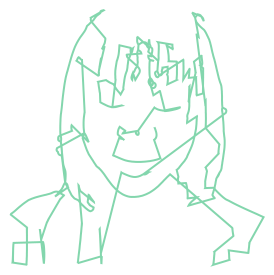

In [16]:
def reorder_center_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(line.centroid)
    return sorted(lines, key=dist)

ordered_by_closest_to_center = reorder_center_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

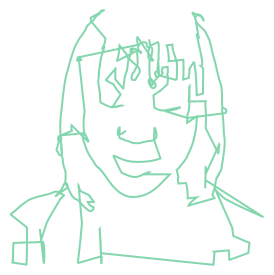

In [17]:
def reorder_start_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[0]))
    return sorted(lines, key=dist)

ordered_by_closest_to_center = reorder_start_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

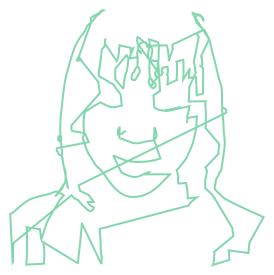

In [18]:
def reorder_end_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[-1]))
    return sorted(lines, key=dist)

ordered_by_closest_to_center = reorder_end_dist(center_geom_lines)
ordered_lines = greedy_reorder(ordered_by_closest_to_center)
merge_naive(ordered_lines)

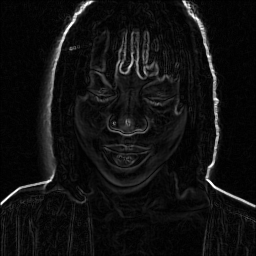

In [19]:
def sobel(gray):
    scale = 1
    delta = 0
    ddepth = cv2.CV_32FC1

    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

grad = sobel(gray)
show(grad)

In [20]:
grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)
grad_blurred /= grad_blurred.max()

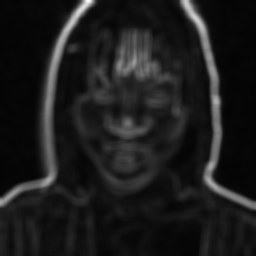

In [21]:
show((grad_blurred * 255).astype(np.uint8))

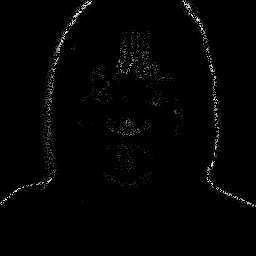

In [22]:
import numpy as np

def sample_grad(grad_blurred):
    gp = grad_blurred.copy()
    gp[gp < (gp.mean() + 0.5 * gp.std())] = 0.0
    prob = gp
    sample_at = (np.random.poisson(prob + 0.001, (256, 256)) > 0).astype(np.uint8)
    
    sampled_grad_pixels = grad * sample_at
    sampled_grad_pixels[0, 0] = 1
    sampled_grad_pixels[-1, -1] = 1
    sampled_grad_pixels[0, -1] = 1
    sampled_grad_pixels[-1, 0] = 1
    
    return sampled_grad_pixels
    
sampled_grad_pixels = sample_grad(grad_blurred)
show(sampled_grad_pixels)

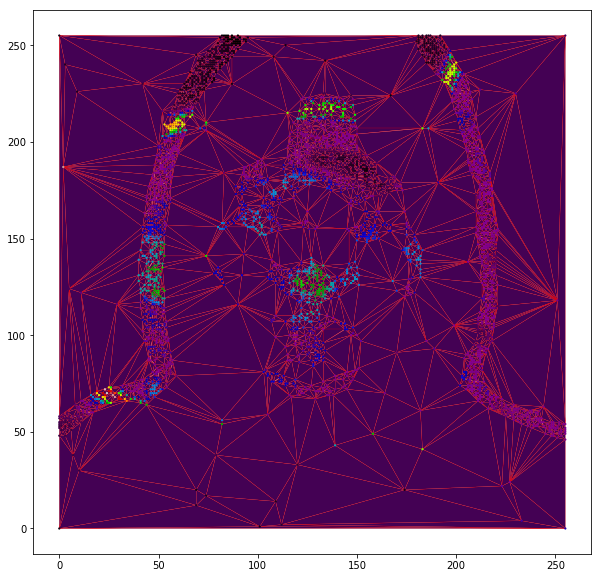

In [23]:
import scipy.spatial

def triangulate(sampled_grad_pixels):
    nonzero_ys, nonzero_xs = np.nonzero(sampled_grad_pixels)
    nonzero_coords = np.dstack((255 - nonzero_ys, nonzero_xs)).squeeze().astype(np.float32)
    tri = scipy.spatial.Delaunay(nonzero_coords)
    return tri
    
tri = triangulate(sampled_grad_pixels)
pixel_vals = grad_blurred[tri.points[:, 1].astype(np.int),  tri.points[:, 0].astype(np.int)]

plt.figure(figsize=(10, 10))
plt.tripcolor(tri.points[:, 1], tri.points[:, 0], tri.simplices, np.ones_like(pixel_vals), edgecolor="red")
plt.scatter(tri.points[:, 1], tri.points[:, 0], c=pixel_vals, cmap='nipy_spectral', s=1.5)

In [25]:
def to_graph(tri):
    nbrs = {i:set() for i in range(len(tri.points))}

    for smplx in tri.simplices:
        nbrs[smplx[0]].add(smplx[1])
        nbrs[smplx[1]].add(smplx[2])
        nbrs[smplx[2]].add(smplx[0])

        nbrs[smplx[1]].add(smplx[0])
        nbrs[smplx[2]].add(smplx[1])
        nbrs[smplx[0]].add(smplx[2])
    
    return nbrs

graph = to_graph(tri)

In [26]:
graph[896]

{833, 834, 873, 895, 897, 914, 934, 958}

In [27]:
import heapq
from collections import defaultdict

def extract_path_rec(from_key, to_key, reverse_paths, out_list):
    next_key = reverse_paths[from_key]
    
    if next_key != to_key and next_key in reverse_paths:
        extract_path_rec(next_key, to_key, reverse_paths, out_list)
        
    out_list.append(next_key)
    return out_list

def extract_path(from_key, to_key, reverse_paths):
    path = extract_path_rec(from_key, to_key, reverse_paths, [])
    path.append(from_key)
    return path

def a_star(start_vertex, goal_vertex, graph, weight, heuristic):
    if start_vertex == goal_vertex:
        return [start_vertex, goal_vertex]
    q = [(0, start_vertex)]
    possible_nexts = set([start_vertex])
    reverse_paths = {}
    cheapest_paths = defaultdict(lambda: float('+inf'))
    cheapest_total = defaultdict(lambda: float('+inf'))
    cheapest_paths[start_vertex] = 0
    while len(possible_nexts) > 0:
        curr_f, curr = heapq.heappop(q)
        possible_nexts.remove(curr)
        if curr == goal_vertex:
            return extract_path(goal_vertex, start_vertex, reverse_paths)
        
        if curr not in graph:
            continue
        nbrs = graph[curr]
        
        for nbr in nbrs:
            h = weight(curr, nbr)
            maybe_best_g = h + cheapest_paths[curr]
            if cheapest_paths[nbr] > maybe_best_g:
                reverse_paths[nbr] = curr
                cheapest_paths[nbr] = maybe_best_g
                f = maybe_best_g + heuristic(nbr, goal_vertex)
                if nbr not in possible_nexts:
                    possible_nexts.add(nbr)
                    heapq.heappush(q, (f, nbr))

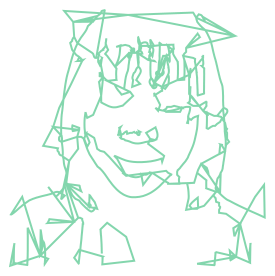

In [28]:
import time
from math import sqrt 

def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

def pt_vert_distance(pt, tri, idx):
    return sqrt(tuple_sq_dist(pt, tri.points[idx]))

def nearest_line(pt, lines, remaining_line_idxs):
    nearest = None
    nearest_idx = None
    flip = False
    closest_dist = 1e10
    for idx in remaining_line_idxs:
        other = lines[idx]
        start_dist = tuple_sq_dist(pt, other.coords[0])
        end_dist = tuple_sq_dist(pt, other.coords[-1])
        if start_dist < closest_dist:
            flip = False
            closest_dist = start_dist
            nearest = other
            nearest_idx = idx
        elif end_dist < closest_dist:
            flip = True
            closest_dist = end_dist
            nearest = other
            nearest_idx = idx
    return nearest, nearest_idx, flip


def mk_heuristic_fn(tri, grad_blurred):
    
    grad_max = grad_blurred.max()

    def distance(i, j):
        i_pos = tri.points[i]
        j_pos = tri.points[j]
        dx = i_pos - j_pos
        return np.linalg.norm(dx)

    def heuristic(i, goal):
        dist = distance(i, goal)
        coords = tri.points[i].astype(np.int)
        edginess = grad_blurred[coords[1], coords[0]]
        return dist + (1.0 - edginess)*10
    return heuristic

def mk_weight_fn(tri, grad_blurred):
    def distance(i, j):
        i_pos = tri.points[i]
        j_pos = tri.points[j]
        dx = i_pos - j_pos
        return np.linalg.norm(dx)

    grad_max = grad_blurred.max()

    def weight(i, j):
        dist = distance(i, j) ** 1.1
        i_pos = tri.points[i]
        j_pos = tri.points[j]

        mid = (i_pos + j_pos).astype(np.int) // 2
        i_pos = i_pos.astype(np.int)
        j_pos = j_pos.astype(np.int)
        edginess = (grad_blurred[mid[1], mid[0]] + grad_blurred[i_pos[1], i_pos[0]] + grad_blurred[j_pos[1], j_pos[0]])/3.0
        return dist + (1.0 - edginess)*10
    return weight

def tuple_sq_dist(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return (dx*dx) + (dy*dy)
    
    
def insert_a_star_connections(lines, tri, graph_copy, grad_blurred):
    weight = mk_weight_fn(tri, grad_blurred)
    heuristic = mk_heuristic_fn(tri, grad_blurred)
    remaining_lines = set(range(len(lines)))
    curr_idx = 0
    out = [lines[curr_idx]]
    remaining_lines.remove(curr_idx)
    pts_added = []
    while len(remaining_lines) > 0:
        curr = lines[curr_idx]
        end_curr = curr.coords[-1]
        dist = float('+inf')
        nearest_tail, nearest_tail_idx, flip = nearest_line(end_curr, lines, remaining_lines)
        
        if flip:
            nearest_tail.coords = list(nearest_tail.coords)[::-1]

        remaining_lines.remove(nearest_tail_idx)
        
        next_start_x, next_start_y = nearest_tail.coords[0]
        goal_pos = next_start_x, next_start_y
        
        goal_smplx_idx = tri.find_simplex(goal_pos)
        goal_smplx = tri.simplices[goal_smplx_idx]
        nearest_smplx_corner_to_goal = min(goal_smplx, key=lambda idx: pt_vert_distance(goal_pos, tri, idx))
        
        curr_smplx_idx = tri.find_simplex(end_curr)
        curr_smplx = tri.simplices[curr_smplx_idx]
        nearest_smplx_corner_to_curr = min(curr_smplx, key=lambda idx: pt_vert_distance(end_curr, tri, idx))
        
        if (nearest_smplx_corner_to_goal != nearest_smplx_corner_to_curr
            and nearest_smplx_corner_to_goal in graph_copy
            and nearest_smplx_corner_to_curr in graph_copy):
            path_between = a_star(nearest_smplx_corner_to_curr, nearest_smplx_corner_to_goal, graph_copy, weight, heuristic)
            
            if path_between is not None:
                for i in range(len(path_between) - 1):
                    p_i = path_between[i]
                    p_next = path_between[i + 1]
                    graph_copy[p_i].remove(p_next)
                    #del graph_copy[p_i]
                    #print('del', p_i)

                pts_between = [tuple(tri.points[idx]) for idx in path_between]
                pts_added.append(geom.LineString(pts_between))
                out.append(geom.LineString(pts_between))
            else:
                print("no path")
        out.append(nearest_tail)
        curr_idx = nearest_tail_idx
    return out, pts_added


#profile:
# %lprun -f nearest_line insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)
# %lprun -f a_star insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)
# %lprun -f insert_a_star_connections insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph)

graph = to_graph(tri)
a_star_connected, added_pts = insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph, grad_blurred)
merged = merge_naive(a_star_connected)
merged

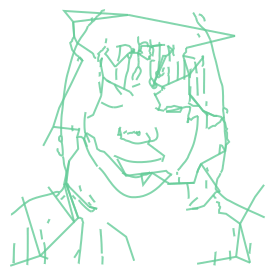

In [29]:
geom.GeometryCollection(a_star_connected)

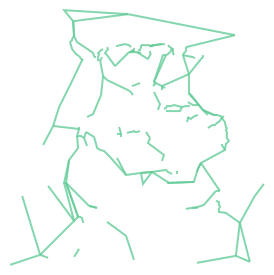

In [30]:
geom.GeometryCollection(added_pts)

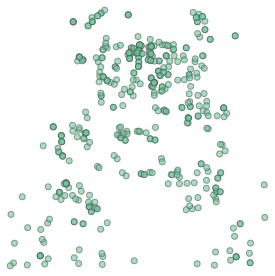

In [31]:
geom.GeometryCollection([geom.Point(line.coords[0]) for line in a_star_connected] + 
                        [geom.Point(line.coords[-1]) for line in a_star_connected])

In [32]:
import descartes as des

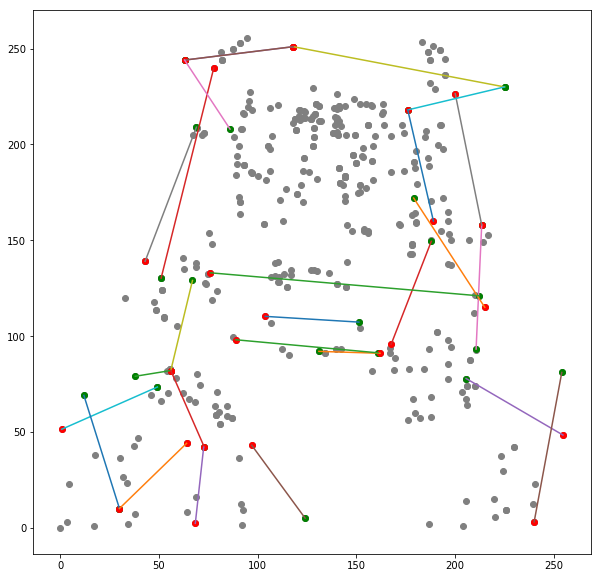

In [33]:
starts = np.asarray([line.coords[0] for line in a_star_connected])
ends = np.asarray([line.coords[-1] for line in a_star_connected])
length = np.asarray([line.length for line in a_star_connected])

long_starts = starts[length > 40]
long_ends = ends[length > 40]

plt.figure(figsize=(10, 10))
plt.scatter(starts[:, 0], starts[:, 1], c='gray')
plt.scatter(ends[:, 0], ends[:, 1], c='gray')
plt.scatter(long_starts[:, 0], long_starts[:, 1], c='green')
plt.scatter(long_ends[:, 0], long_ends[:, 1], c='red')

for start, end in zip(long_starts, long_ends):
    plt.plot([start[0], end[0]], [start[1], end[1]])

(array([74., 60., 26., 16., 12.,  6.,  4.,  8.,  2.,  3.,  2.,  1.,  3.,
         2.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  1.41421356,   7.62191186,  13.82961017,  20.03730847,
         26.24500677,  32.45270507,  38.66040338,  44.86810168,
         51.07579998,  57.28349828,  63.49119659,  69.69889489,
         75.90659319,  82.11429149,  88.3219898 ,  94.5296881 ,
        100.7373864 , 106.9450847 , 113.15278301, 119.36048131,
        125.56817961, 131.77587791, 137.98357622, 144.19127452,
        150.39897282, 156.60667112, 162.81436943, 169.02206773,
        175.22976603, 181.43746433, 187.64516264]),
 <a list of 30 Patch objects>)

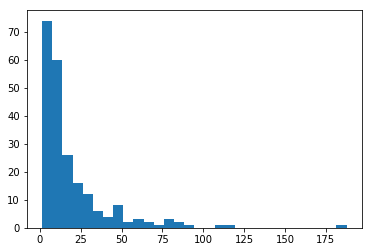

In [34]:
plt.hist(length, bins=30)

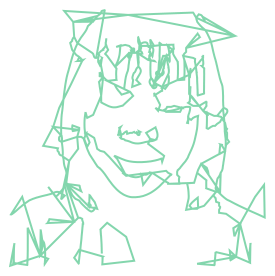

In [35]:
merged

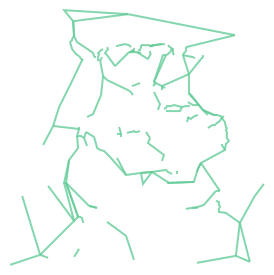

In [36]:
geom.GeometryCollection(added_pts)

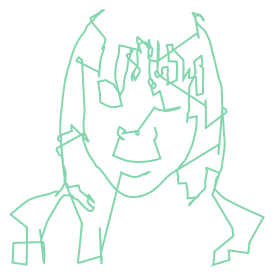

In [37]:
merge_naive(greedy_reorder(reorder_center_dist(center_geom_lines)))

1. make few canny edges
2. solve for path
3. pick connectors from dense edges

aka

1. make lots of canny edges
2. solve for path by picking points in between ends and snapping them to nearest lines

or

1. make edges
2. a* w/ heuristics based on edgi-ness of pixel along delauncy triangulion of face or polar grid

+

1. centerline optimization

In [38]:
def pipeline(gray):
    
    edges = raster_edges(gray)
    edges[:, 240:] = 255
    edges[:, :16] = 255
    
    cv2.imwrite("tmp.bmp", edges)
    !.\potrace-1.16.win64\potrace.exe tmp.bmp -o tmp.geojson -b geojson

    with open('tmp.geojson') as fp:
        geojson = json.load(fp)

    shapes = [geom.shape(feature["geometry"]) for feature in geojson['features']]
    
    center_geom_lines = extract_centerlines(shapes)

    center_geom_lines = explode_multilines(center_geom_lines)

    center_geom_lines = [line for line in center_geom_lines 
                         if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

    grad = sobel(gray)

    grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)

    grad_samples = sample_grad(grad_blurred)

    tri = triangulate(grad_samples)

    graph = to_graph(tri)
    
    a_star_connected, added_pts = insert_a_star_connections(reorder_start_dist(center_geom_lines), tri, graph, grad_blurred)
    merged = merge_naive(a_star_connected)
    return merged

# %lprun -u 0.001 -f pipeline pipeline(examples[0])
# %lprun -u 0.001 -f insert_a_star_connections pipeline(examples[0])

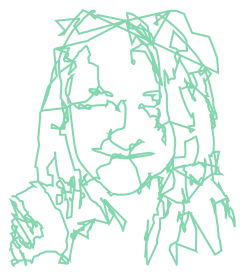

In [39]:
pipeline(examples[0])

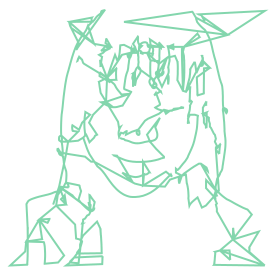

In [40]:
pipeline(examples[1])

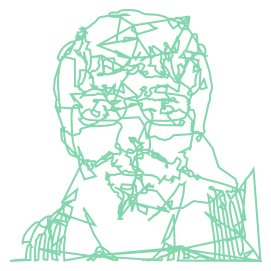

In [41]:
pipeline(examples[2])

In [42]:
type(geom.Point) == geom.Polygon

False

In [43]:
import torch

In [44]:
from resfcn256 import ResFCN256

In [45]:
prnet = ResFCN256()
state_dict = torch.load('./prnet_state_dict.pth')
prnet.load_state_dict(state_dict['prnet'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [46]:
prnet

ResFCN256(
  (block0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): ResBlock(
    (shortcut_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
    (conv1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (normalizer_fn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_fn): ReLU(inplace)
  )
  (block2): ResBlock(
    (shortcut_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (normalizer_fn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation_fn): ReLU(inplace)
  )
  (block3): ResBlock(
  

In [47]:
from torchvision import transforms

In [144]:
transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

prnet = prnet.eval().cuda()

def infer(rgb, magic=1.1):
    with torch.no_grad():
        tensor = transform_img(rgb)
        tensor = tensor.unsqueeze(0).cuda()
        result = prnet(tensor) * magic
        result = result[0:2] * 255
        result = result.byte()
        result = result.squeeze().cpu().numpy()
        result = np.transpose(result, (1, 2, 0))
        
        return result

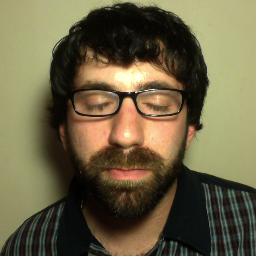

In [145]:
show(test)

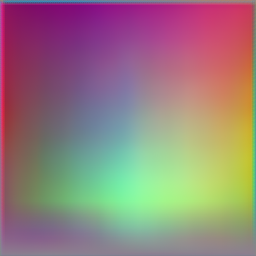

In [146]:
show(infer(test))

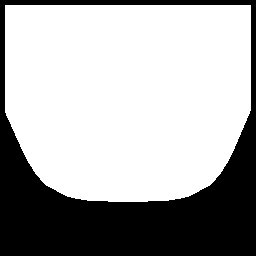

In [147]:
uv_weight = cv2.imread('prnet_uv_data/uv_weight_mask_gdh.png', cv2.IMREAD_GRAYSCALE)
uv_mask = cv2.threshold(uv_weight, 10, 255, cv2.THRESH_BINARY)[1]
show(uv_mask)

In [148]:
import dlib
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('./shape_predictor_5_face_landmarks.dat')

def centercrop_face(rgb):    
    dets = detector(rgb, 1)
    faces = dlib.full_object_detections()
    for detection in dets:
        faces.append(sp(rgb, detection))
    images = dlib.get_face_chips(rgb, faces, size=256)
    return images[0], faces[0]

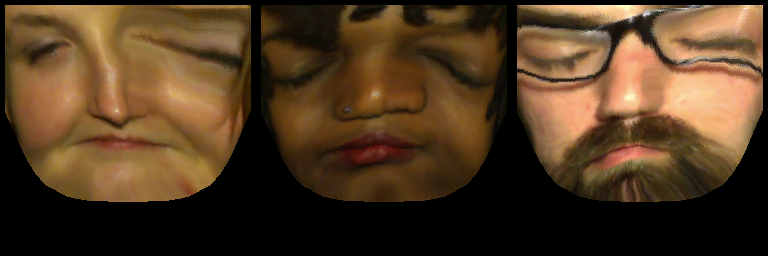

In [164]:
bin_mask = uv_mask.copy()
bin_mask[bin_mask > 0] = 1
bin_mask = bin_mask[:, :, np.newaxis]

def splat(prnet_result, img):
    masked = prnet_result * bin_mask
    xy = masked[:, :, :2].reshape(-1, 2)
    result = np.zeros_like(masked, dtype=np.uint8)
    result = img[xy[:, 1], xy[:, 0]]
    return result.reshape(256, 256, 3) * bin_mask


splatteds = []
for path in example_paths:
    test = cv2.imread(path, cv2.IMREAD_COLOR)
    test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)

    cropped, bbox = centercrop_face(test)
    uv_idxs = infer(cropped, magic=1)
    splatteds.append(splat(uv_idxs, cropped))
show(np.concatenate(splatteds, 1))

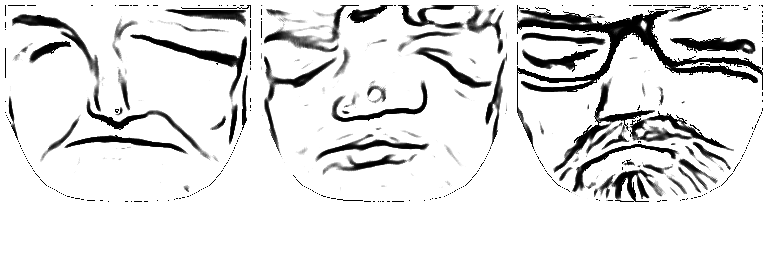

In [220]:
big_mask = bin_mask[:, :, 0]
#big_mask = cv2.erode(bin_mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
edgeses = [raster_edges(cv2.cvtColor(splatted, cv2.COLOR_RGB2GRAY),
                       canny=(150, 200), sigma1=1.5, sigma2=2.9, tau=0.99) * big_mask  for splatted in splatteds]
for edges in edgeses:
    edges[big_mask==0] = 255
show(np.concatenate(edgeses, 1))

In [ ]:
show(big_mask)

In [203]:
bin_mask[:, :, 0].shape

(256, 256)